<a href="https://colab.research.google.com/github/nvrel/reco_project/blob/main/projet_systeme_recommandation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/recommendation_system'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For data processing and algorithms
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from collections import defaultdict
import urllib.request
import zipfile
import os

In [16]:
# List all files in the directory
file_list = os.listdir(drive_path)

# Iterate through the files and load CSVs
for file_name in file_list:
    if file_name.endswith('.csv'):
        # Create a variable name from the file name (without extension)
        variable_name = file_name.replace('.csv', '')

        # Construct the full path to the file
        file_path = os.path.join(drive_path, file_name)

        try:
            # Read the CSV into a pandas DataFrame
            df = pd.read_csv(file_path)

            # Assign the DataFrame to the variable name
            globals()[variable_name] = df
            print(f"Loaded '{file_name}' into DataFrame '{variable_name}'")

        except Exception as e:
            print(f"Error loading '{file_name}': {e}")

# You can now access your DataFrames using the variable names
# For example, if you had a file named 'users.csv', you can access it as:
# print(users.head())


Loaded 'articles.csv' into DataFrame 'articles'
Loaded 'customers.csv' into DataFrame 'customers'
Loaded 'transactions_train.csv' into DataFrame 'transactions_train'


In [ ]:
print(f"Nombre d'articles : {len(articles)}")
print(f"Nombre de clients : {len(customers)}")
print(f"Nombre de transactions : {len(transactions_train)}")

Nombre d'articles : 105542
Nombre de clients : 1371980
Nombre de transactions : 31788324


In [ ]:
print("\nStructure des DataFrames chargés:")

# Get all variables in the current scope
all_variables = list(globals().keys())

# Filter for variables that are pandas DataFrames and were likely loaded from the directory
dataframe_variables = [var for var in all_variables if isinstance(globals()[var], pd.DataFrame) and var in ['articles', 'customers', 'transactions_train']]

if not dataframe_variables:
    print("Aucun DataFrame (articles, customers, transactions_train) trouvé.")
else:
    for df_name in dataframe_variables:
        print(f"\n--- DataFrame: {df_name} ---")
        df = globals()[df_name]
        print("Infos:")
        df.info()
        #print("\n---------------------------")



Structure des DataFrames chargés:

--- DataFrame: articles ---
Infos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null 

In [ ]:
# Pour un affichage plus lisible des graphiques
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [ ]:
customers["postal_code"].value_counts()

,count
postal_code,
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8,261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1,159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7,157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145,156
...,...
8bfee6a3c5176fcaf41946099473b59fc56937c7a7369c020fc336d9497b0610,1
23bcd86dc11e0a0dc7f6cd7c90c67628824067566824b4d32e32247f187bc03f,1
4ec1eeb2488423a2913d5b37a1947269cb20ba3a2a80fc6566f695b33b661f47,1


In [ ]:
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'], format='%Y-%m-%d')
# (2) Calculer la date la plus ancienne et la date la plus récente
date_min = transactions_train['t_dat'].min()
date_max = transactions_train['t_dat'].max()

# (3) Afficher les résultats
print("Date de transaction la plus ancienne :", date_min.date())
print("Date de transaction la plus récente  :", date_max.date())

Date de transaction la plus ancienne : 2018-09-20
Date de transaction la plus récente  : 2020-09-22


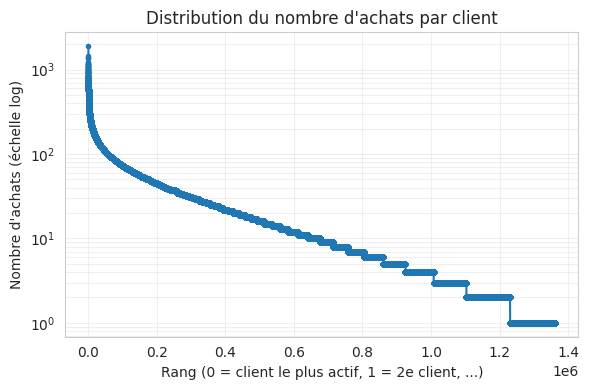

In [ ]:
# (Re)calcule des nombres d'achats par client
counts_per_customer = transactions_train.groupby('customer_id').size()

# Tri décroissant des comptes, sans log
counts_sorted = counts_per_customer.sort_values(ascending=False)

# Rang de chaque client (0 = client le plus actif, 1 = 2e, etc.)
ranks = np.arange(len(counts_sorted))

plt.figure(figsize=(6, 4))
plt.plot(ranks, counts_sorted.values, marker='o', linestyle='-', markersize=3)

# Passage de l'axe Y en échelle logarithmique
plt.yscale('log')

plt.xlabel("Rang (0 = client le plus actif, 1 = 2e client, ...)")
plt.ylabel("Nombre d'achats (échelle log)")
plt.title("Distribution du nombre d'achats par client")
plt.grid(alpha=0.3, which="both")  # 'which="both"' pour avoir la grille en log aussi
plt.tight_layout()
plt.show()

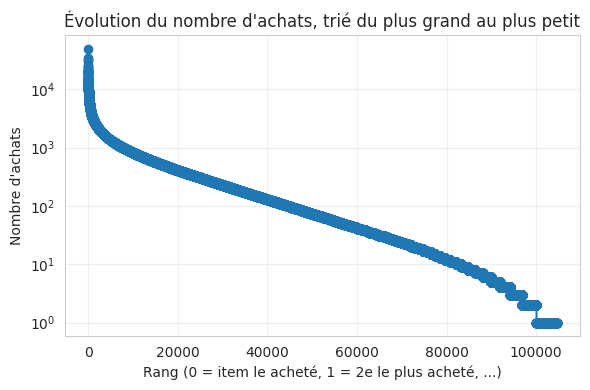

In [ ]:
counts_per_article = transactions_train.groupby('article_id').size()
counts_desc = counts_per_article.sort_values(ascending=False)
ranks = np.arange(len(counts_desc))
plt.figure(figsize=(6, 4))

plt.plot(ranks, counts_desc.values, marker='o', linestyle='-')
# Passage de l'axe Y en échelle logarithmique
plt.yscale('log')

plt.xlabel("Rang (0 = item le acheté, 1 = 2e le plus acheté, ...)")
plt.ylabel("Nombre d'achats")
plt.title("Évolution du nombre d'achats, trié du plus grand au plus petit")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#Grouper par semaine (lundi comme début de semaine) via pd.Grouper
#    Ici on n’ajoute pas de nouvelle colonne, on grouppe directement sur 't_dat'.
weekly_txns = (
    transactions_train
    .groupby(pd.Grouper(key='t_dat', freq='W-MON'))['customer_id']
    .count()
    .reset_index(name='txns_count')
)

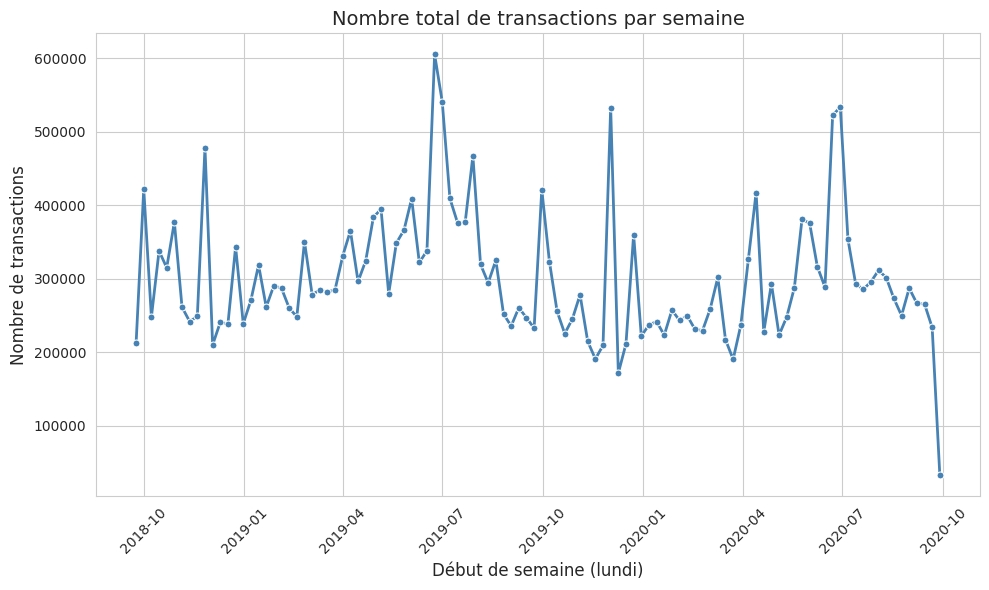

In [ ]:
# 3. Tracer la série hebdomadaire
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=weekly_txns,
    x='t_dat',
    y='txns_count',
    marker='o',
    color='steelblue',
    linewidth=2,
    markersize=5
)
plt.title("Nombre total de transactions par semaine", fontsize=14)
plt.xlabel("Début de semaine (lundi)", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

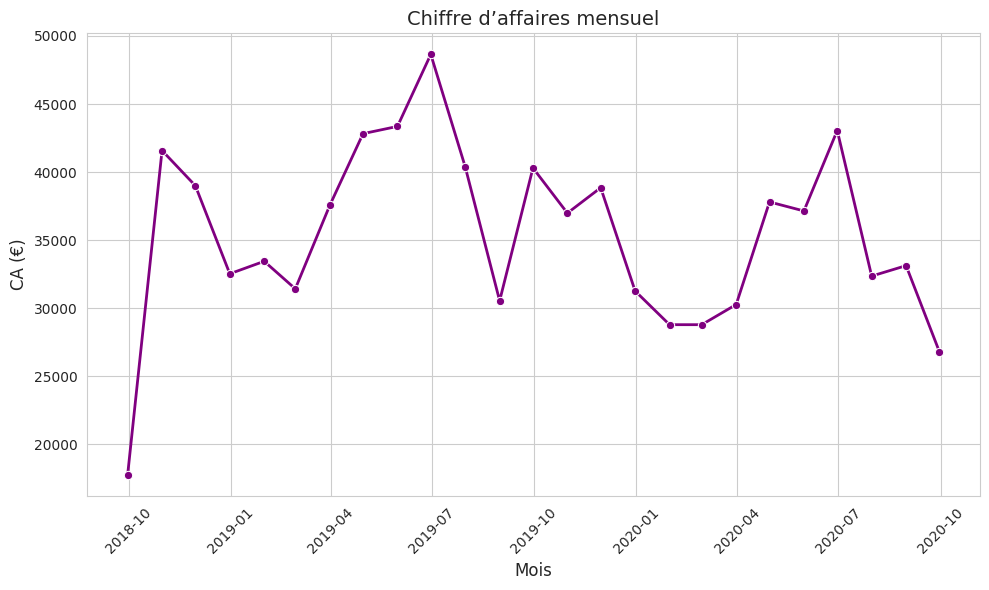

In [ ]:
# -------------------------------------------------------------------
# Série temporelle du chiffre d’affaires mensuel
# -------------------------------------------------------------------
monthly_revenue = (
    transactions_train
    .groupby(pd.Grouper(key='t_dat', freq='M'))['price']
    .sum()
    .reset_index(name='ca')
)
plt.figure()
sns.lineplot(
    data=monthly_revenue,
    x='t_dat',
    y='ca',
    marker='o',
    color='purple',
    linewidth=2,
    markersize=6
)
plt.title("Chiffre d’affaires mensuel", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("CA (€)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


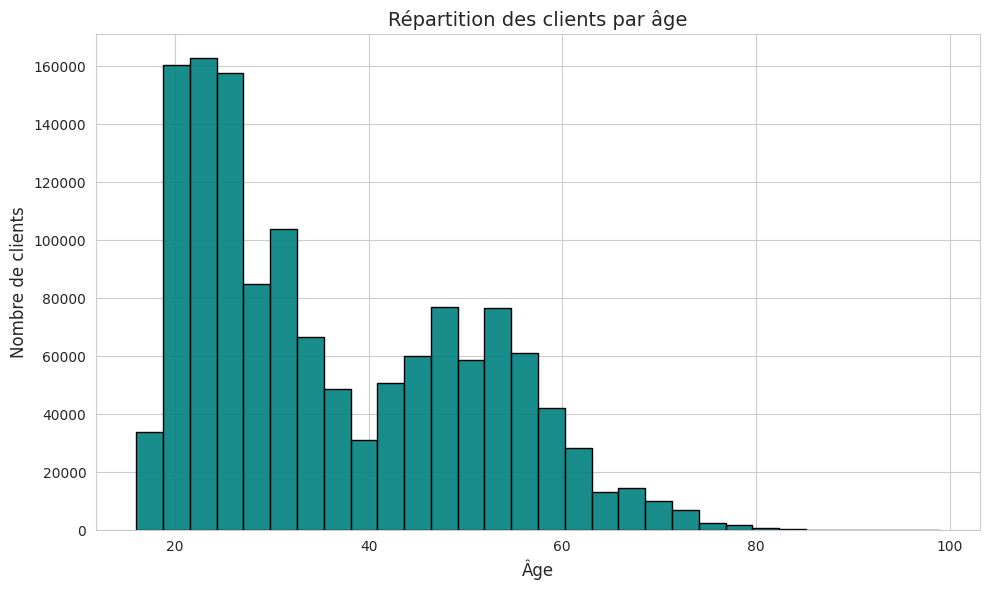

In [ ]:
# -------------------------------------------------------------------
# Répartition des clients par âge
# -------------------------------------------------------------------
age_non_null = customers['age'].dropna()
plt.figure()
sns.histplot(
    age_non_null,
    bins=30,
    color='teal',
    alpha=0.9,
    edgecolor='black'
)
plt.title("Répartition des clients par âge", fontsize=14)
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Nombre de clients", fontsize=12)
plt.tight_layout()
plt.show()

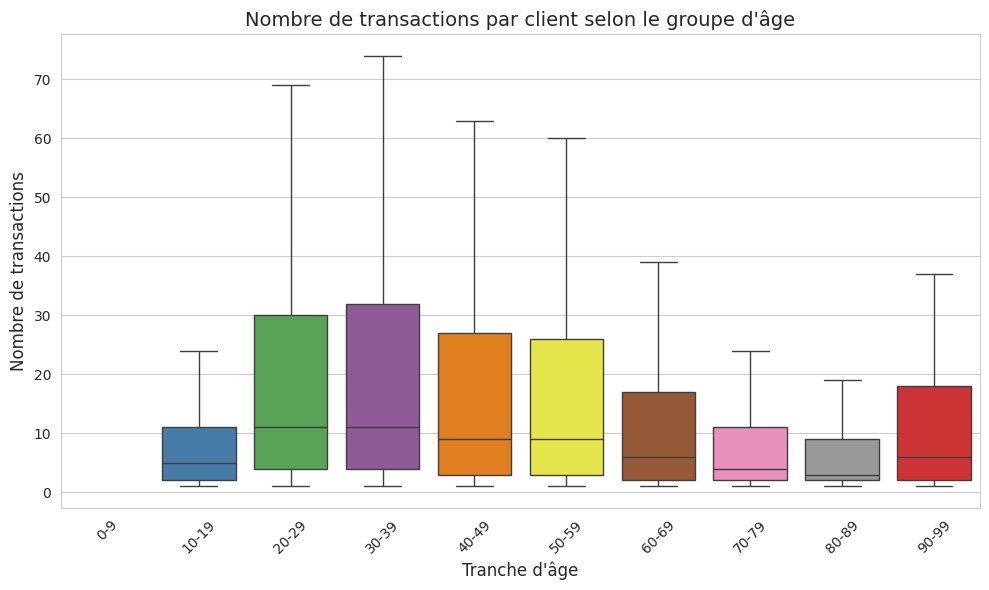

In [ ]:
# -------------------------------------------------------------------
# Âge vs. Nombre de transactions par client (boxplot par tranche d’âge)
# -------------------------------------------------------------------
# Nombre de transactions par client (déjà dans counts_per_customer)
df_txns_customer = counts_per_customer.rename_axis('customer_id').reset_index(name='txns_count')
# Joindre l'âge
df_client_stats = df_txns_customer.merge(
    customers[['customer_id', 'age']],
    on='customer_id',
    how='left'
).dropna(subset=['age'])
# Créer les tranches d’âge sans ajouter de colonne au DataFrame original
bins = list(range(0, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]
df_client_stats['age_group'] = pd.cut(df_client_stats['age'], bins=bins, labels=labels, right=False)
plt.figure()
sns.boxplot(
    data=df_client_stats,
    x='age_group',
    y='txns_count',
    showfliers=False,
    palette='Set1'
)
plt.title("Nombre de transactions par client selon le groupe d'âge", fontsize=14)
plt.xlabel("Tranche d'âge", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


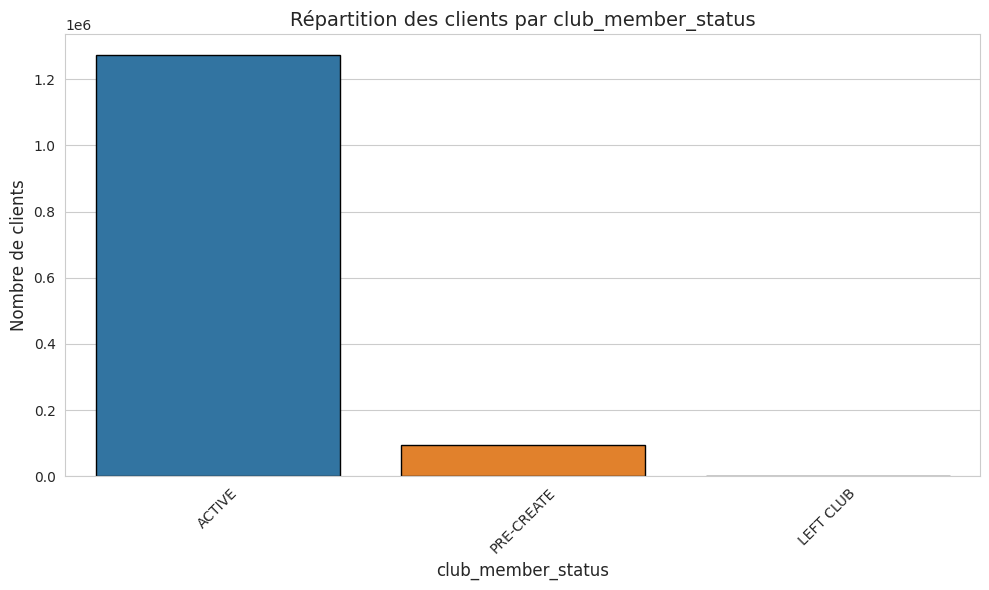

In [ ]:
# -------------------------------------------------------------------
# Répartition du 'club_member_status'
# -------------------------------------------------------------------
club_counts = customers['club_member_status'].value_counts(dropna=False).reset_index()
club_counts.columns = ['club_member_status', 'count']
plt.figure()
sns.barplot(
    data=club_counts,
    x='club_member_status',
    y='count',
    palette='tab10',
    edgecolor='black'
)
plt.title("Répartition des clients par club_member_status", fontsize=14)
plt.xlabel("club_member_status", fontsize=12)
plt.ylabel("Nombre de clients", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


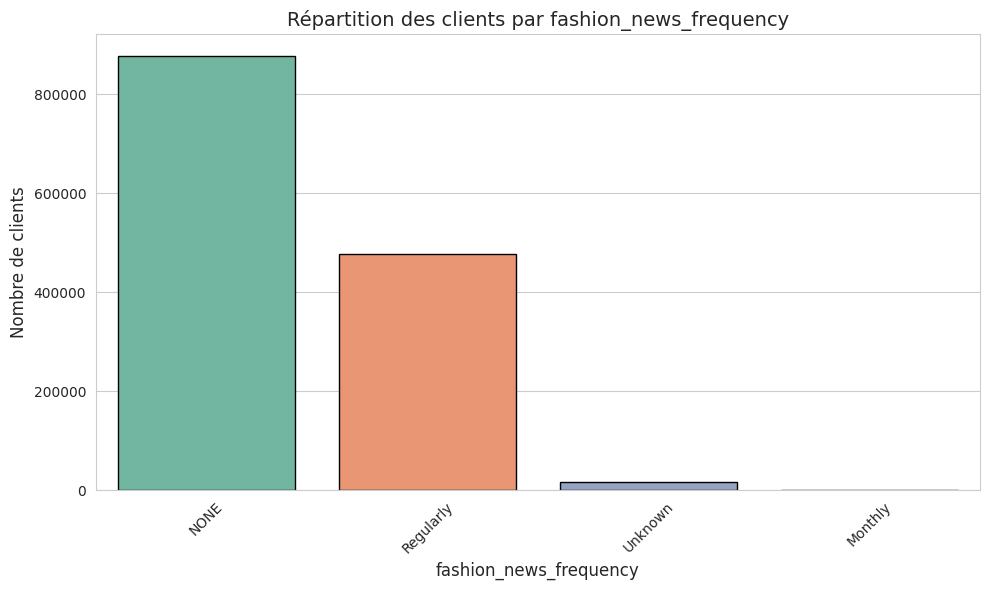

In [ ]:
# -------------------------------------------------------------------
# Répartition du 'fashion_news_frequency'
# -------------------------------------------------------------------
news_counts = customers['fashion_news_frequency'].fillna('Unknown').value_counts().reset_index()
news_counts.columns = ['fashion_news_frequency', 'count']
plt.figure()
sns.barplot(
    data=news_counts,
    x='fashion_news_frequency',
    y='count',
    palette='Set2',
    edgecolor='black'
)
plt.title("Répartition des clients par fashion_news_frequency", fontsize=14)
plt.xlabel("fashion_news_frequency", fontsize=12)
plt.ylabel("Nombre de clients", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

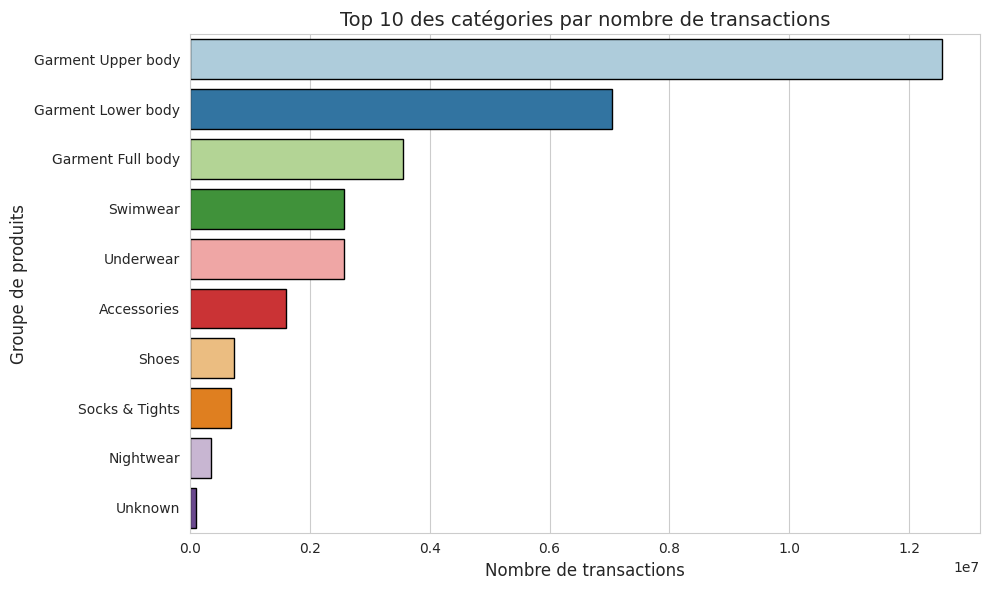

In [ ]:
# -------------------------------------------------------------------
# Distribution par catégorie / groupe de produits (top 10)
# -------------------------------------------------------------------
txns_with_prod = transactions_train.merge(
    articles[['article_id', 'product_group_name']],
    on='article_id',
    how='left'
)
cat_counts = txns_with_prod['product_group_name'].value_counts().reset_index()
cat_counts.columns = ['product_group_name', 'txns_count']
top10_cat = cat_counts.head(10)
plt.figure()
sns.barplot(
    data=top10_cat,
    x='txns_count',
    y='product_group_name',
    palette='Paired',
    edgecolor='black'
)
plt.title("Top 10 des catégories par nombre de transactions", fontsize=14)
plt.xlabel("Nombre de transactions", fontsize=12)
plt.ylabel("Groupe de produits", fontsize=12)
plt.tight_layout()
plt.show()

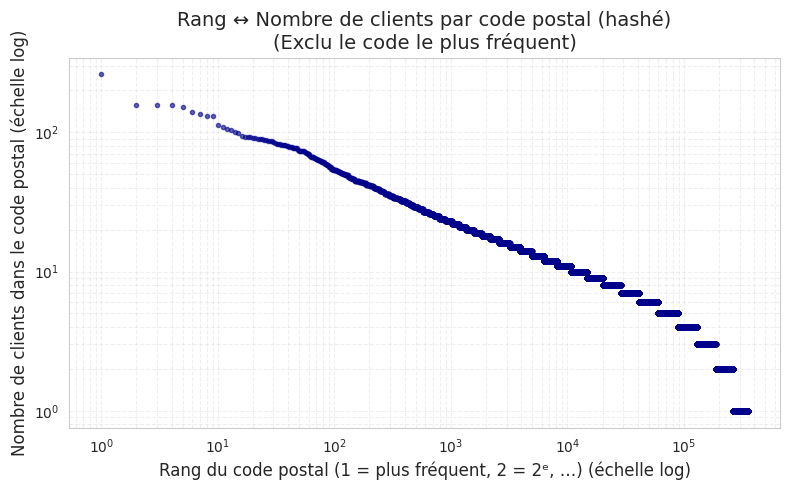

In [ ]:
# 1. Récupérer la série des codes postaux actifs (hashés) ayant au moins 1 transaction
active_customer_ids = transactions_train['customer_id'].unique()
active_postal_codes = customers.loc[
    customers['customer_id'].isin(active_customer_ids),
    'postal_code'
]

# 2. Compter le nombre de clients par code postal
counts_per_postal = active_postal_codes.value_counts()

# 3. Exclure le code postal le plus fréquent (celui qu'on considère comme "Unknown")
most_common_code = counts_per_postal.idxmax()
filtered_counts = counts_per_postal.drop(index=most_common_code)

# 4. Trier les effectifs restants du plus grand au plus petit
sorted_counts = filtered_counts.sort_values(ascending=False).values

# 5. Construire le vecteur des rangs (1, 2, 3, ..., len(sorted_counts))
ranks = np.arange(1, len(sorted_counts) + 1)

# 6. Tracer la courbe rang vs effectif en échelle log-log
plt.figure(figsize=(8, 5))
plt.plot(ranks, sorted_counts, marker='.', linestyle='none', alpha=0.6, color='darkblue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Rang du code postal (1 = plus fréquent, 2 = 2ᵉ, …) (échelle log)", fontsize=12)
plt.ylabel("Nombre de clients dans le code postal (échelle log)", fontsize=12)
plt.title("Rang ↔ Nombre de clients par code postal (hashé)\n(Exclu le code le plus fréquent)", fontsize=14)
plt.grid(which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

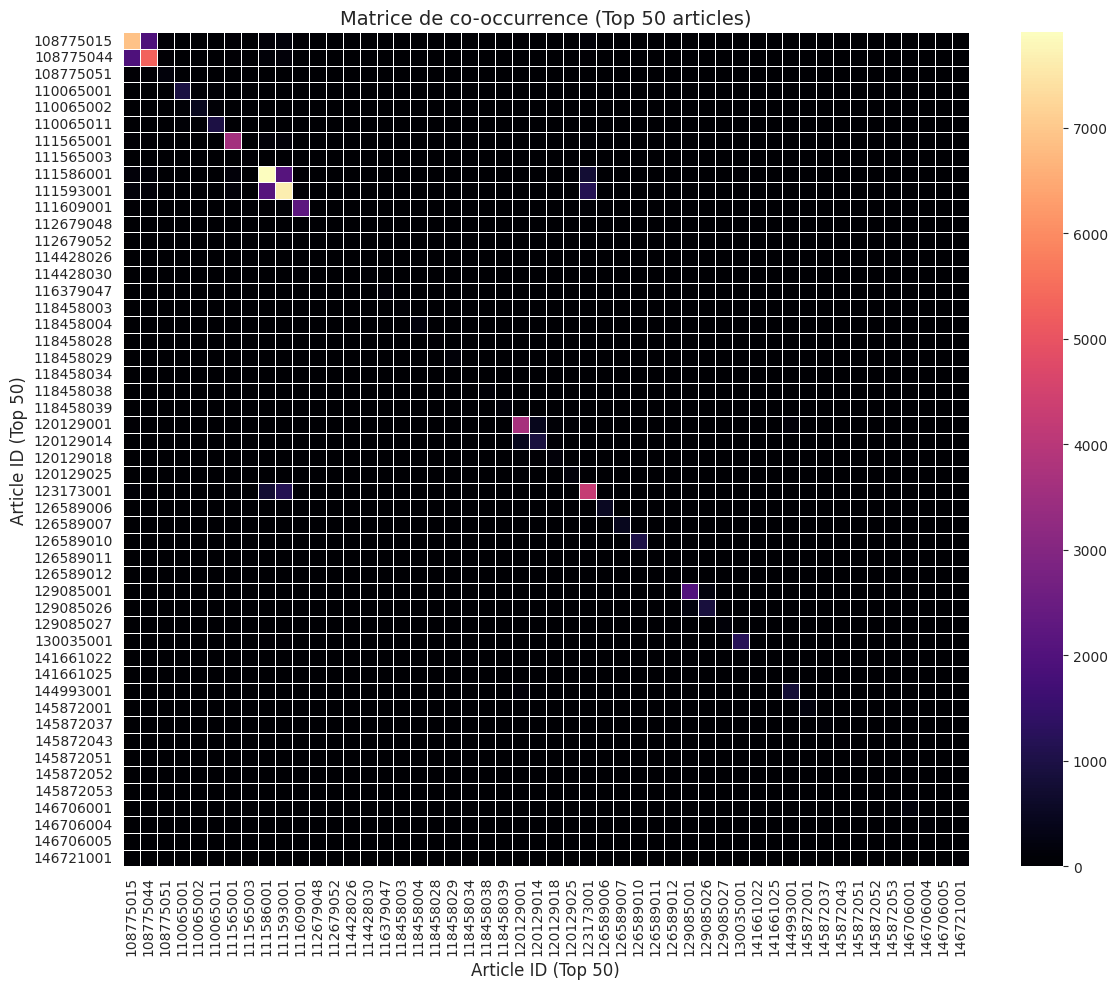

In [ ]:
# -------------------------------------------------------------------
# Matrice de co-occurrence (heatmap) sur le top 50 articles
# -------------------------------------------------------------------
top50 = counts_per_article.head(50).index.tolist()
txns_top50 = transactions_train[transactions_train['article_id'].isin(top50)]
# Construire matrice client × article binaire (sans ajouter de colonne)
user_item = txns_top50.groupby(['customer_id', 'article_id']).size().unstack(fill_value=0)
user_item_bin = (user_item > 0).astype(int)
cooccurrence = user_item_bin.T.dot(user_item_bin)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cooccurrence,
    cmap='magma',
    cbar=True,
    linewidths=0.5
)
plt.title("Matrice de co-occurrence (Top 50 articles)", fontsize=14)
plt.xlabel("Article ID (Top 50)", fontsize=12)
plt.ylabel("Article ID (Top 50)", fontsize=12)
plt.tight_layout()
plt.show()

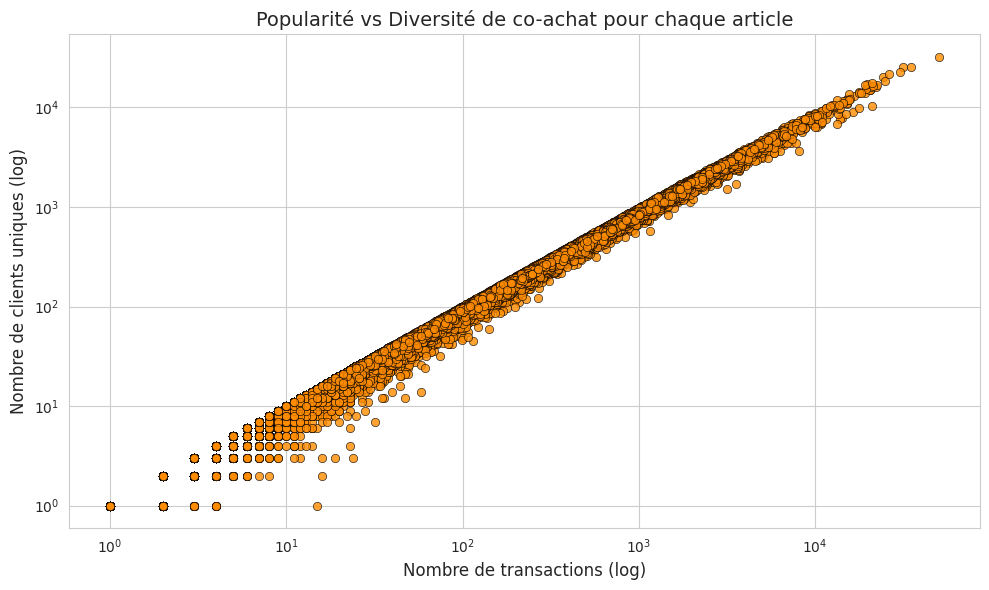

In [ ]:
# -------------------------------------------------------------------
# Nuage de points “popularité vs diversité de co-achat” pour chaque article
# -------------------------------------------------------------------
popularity = counts_per_article.rename_axis('article_id').reset_index(name='txns_count')
unique_clients = transactions_train.groupby('article_id')['customer_id'].nunique().reset_index(name='unique_clients')
df_article_metrics = popularity.merge(unique_clients, on='article_id')
plt.figure()
sns.scatterplot(
    data=df_article_metrics,
    x='txns_count',
    y='unique_clients',
    alpha=0.8,
    color='darkorange',
    edgecolor='black',
    linewidth=0.5
)
plt.xscale('log')
plt.yscale('log')
plt.title("Popularité vs Diversité de co-achat pour chaque article", fontsize=14)
plt.xlabel("Nombre de transactions (log)", fontsize=12)
plt.ylabel("Nombre de clients uniques (log)", fontsize=12)
plt.tight_layout()
plt.show()

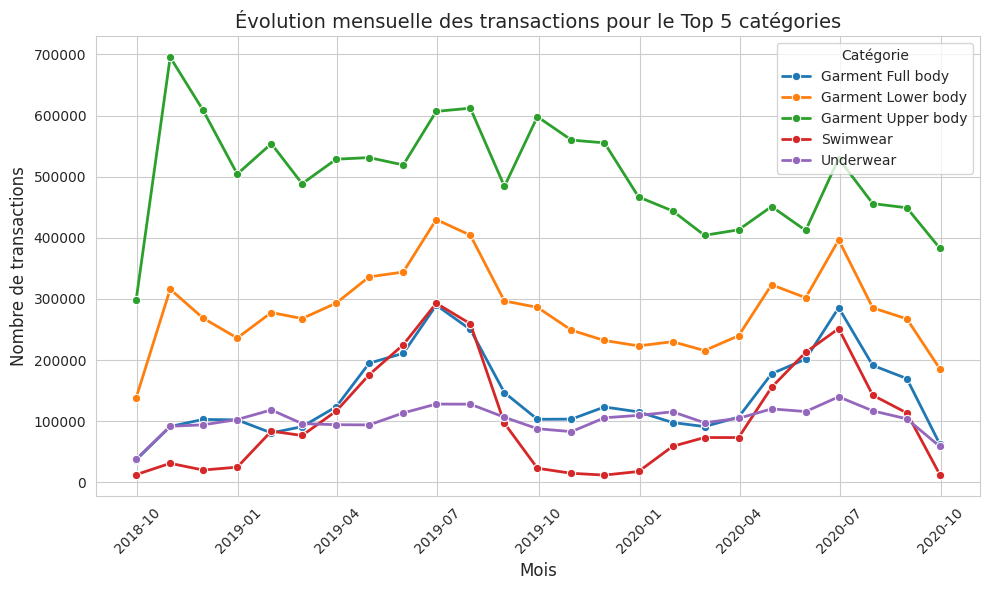

In [ ]:
# -------------------------------------------------------------------
# 13. Séries temporelles par catégorie (top 5 catégories)
# -------------------------------------------------------------------
top5_categories = cat_counts['product_group_name'].head(5).tolist()
df_time_cat = (
    transactions_train
    .merge(articles[['article_id', 'product_group_name']], on='article_id', how='left')
    .query("product_group_name in @top5_categories")
    .groupby([pd.Grouper(key='t_dat', freq='M'), 'product_group_name'])['article_id']
    .count()
    .reset_index(name='txns_count')
)
plt.figure()
sns.lineplot(
    data=df_time_cat,
    x='t_dat',
    y='txns_count',
    hue='product_group_name',
    palette='tab10',
    marker='o',
    linewidth=2,
    markersize=6
)
plt.title("Évolution mensuelle des transactions pour le Top 5 catégories", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Catégorie")
plt.tight_layout()
plt.show()

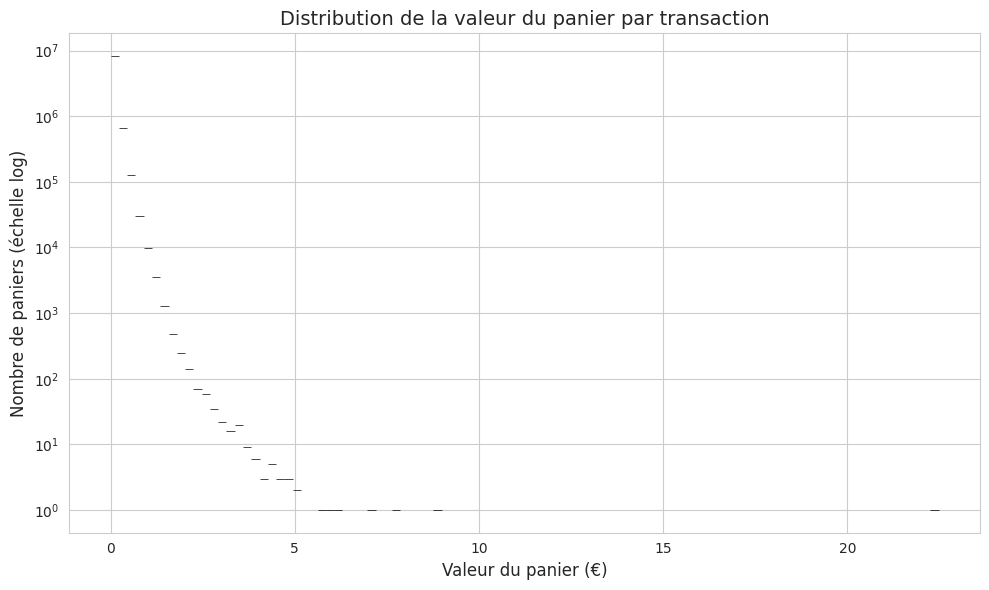

In [ ]:
# -------------------------------------------------------------------
# 14. Distribution de la valeur du panier par transaction
# -------------------------------------------------------------------
basket_values = (
    transactions_train
    .groupby(['customer_id', 't_dat'])['price']
    .sum()
    .reset_index(name='basket_value')
)
plt.figure()
sns.histplot(
    basket_values['basket_value'],
    bins=100,
    log_scale=(False, True),
    color='goldenrod',
    alpha=0.9,
    edgecolor='black'
)
plt.title("Distribution de la valeur du panier par transaction", fontsize=14)
plt.xlabel("Valeur du panier (€)", fontsize=12)
plt.ylabel("Nombre de paniers (échelle log)", fontsize=12)
plt.tight_layout()
plt.show()

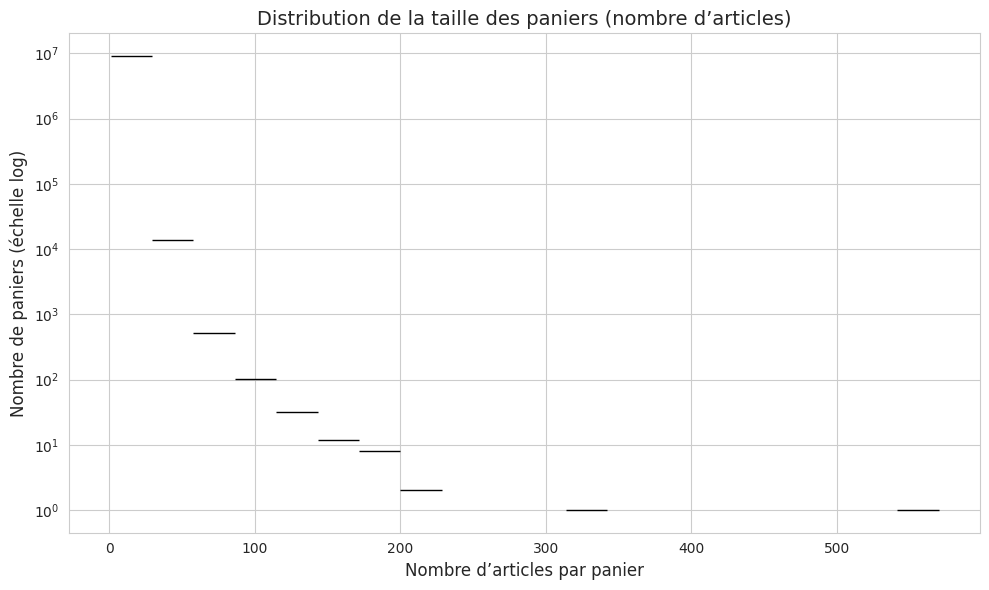

In [ ]:
# -------------------------------------------------------------------
# 15. Distribution de la taille des paniers (nombre d’articles par panier)
# -------------------------------------------------------------------
basket_sizes = (
    transactions_train
    .groupby(['customer_id', 't_dat'])['article_id']
    .count()
    .reset_index(name='basket_size')
)
plt.figure()
sns.histplot(
    basket_sizes['basket_size'],
    bins=20,
    log_scale=(False, True),
    color='slateblue',
    alpha=0.9,
    edgecolor='black'
)
plt.title("Distribution de la taille des paniers (nombre d’articles)", fontsize=14)
plt.xlabel("Nombre d’articles par panier", fontsize=12)
plt.ylabel("Nombre de paniers (échelle log)", fontsize=12)
plt.tight_layout()
plt.show()

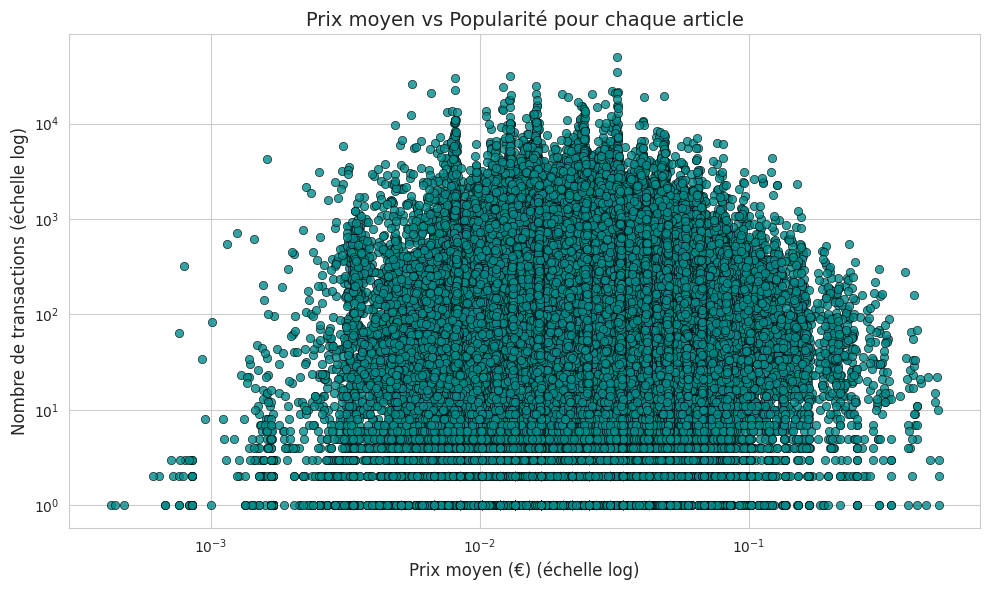

In [ ]:
# -------------------------------------------------------------------
# 16. Nuage de points “prix moyen vs popularité” par article
# -------------------------------------------------------------------
avg_price = transactions_train.groupby('article_id')['price'].mean().reset_index(name='avg_price')
df_price_pop = popularity.merge(avg_price, on='article_id')
plt.figure()
sns.scatterplot(
    data=df_price_pop,
    x='avg_price',
    y='txns_count',
    alpha=0.8,
    color='darkcyan',
    edgecolor='black',
    linewidth=0.5
)
plt.xscale('log')
plt.yscale('log')
plt.title("Prix moyen vs Popularité pour chaque article", fontsize=14)
plt.xlabel("Prix moyen (€) (échelle log)", fontsize=12)
plt.ylabel("Nombre de transactions (échelle log)", fontsize=12)
plt.tight_layout()
plt.show()

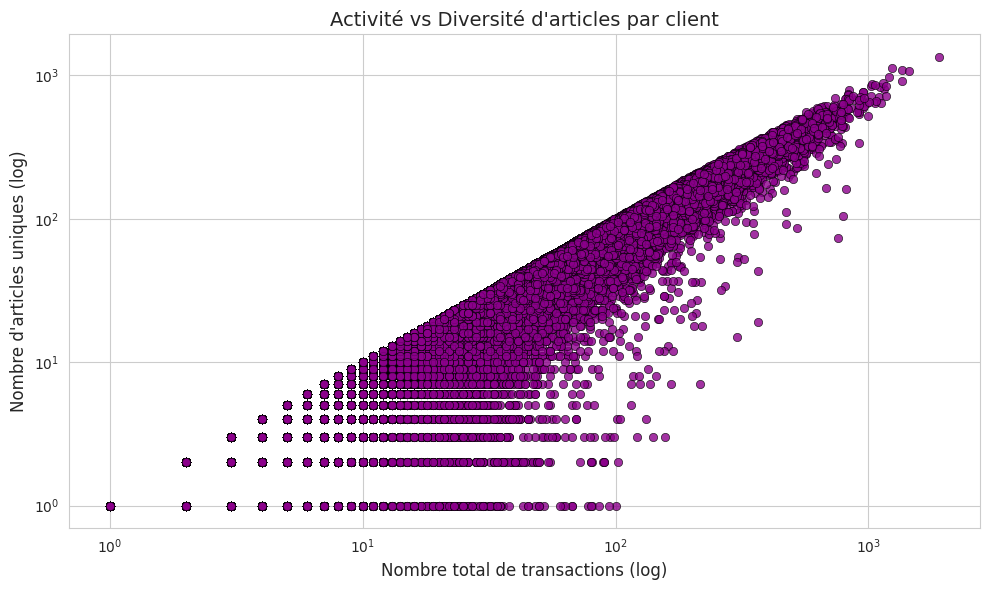

In [ ]:
# -------------------------------------------------------------------
# 17. Nuage de points “activité du client vs diversité d’articles”
# -------------------------------------------------------------------
unique_articles_per_client = transactions_train.groupby('customer_id')['article_id'].nunique().reset_index(name='unique_articles')
df_client_div = df_txns_customer.merge(unique_articles_per_client, on='customer_id')
plt.figure()
sns.scatterplot(
    data=df_client_div,
    x='txns_count',
    y='unique_articles',
    alpha=0.8,
    color='darkmagenta',
    edgecolor='black',
    linewidth=0.5
)
plt.xscale('log')
plt.yscale('log')
plt.title("Activité vs Diversité d'articles par client", fontsize=14)
plt.xlabel("Nombre total de transactions (log)", fontsize=12)
plt.ylabel("Nombre d'articles uniques (log)", fontsize=12)
plt.tight_layout()
plt.show()